In [1]:
import time
import datetime

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds


from transformers import (TFAutoModelWithLMHead, AutoTokenizer, 
    TFTrainer, TFTrainingArguments, TFT5ForConditionalGeneration, T5Config)

In [2]:
tf.__version__

'2.5.0-dev20201029'

### Define Model

In [3]:
class TFT5(TFT5ForConditionalGeneration):
    def __init__(self, *args, log_dir = None, cache_dir = None, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_tracker= tf.keras.metrics.Mean(name = 'loss') 
    
    @tf.function
    def train_step(self, data):
        x, _= data
        y = x["labels"]
        y = tf.reshape(y, [-1, 1])
        with tf.GradientTape() as tape:
            outputs = self(x, training = True)
            loss = outputs[0]
            logits = outputs[1]
            loss = tf.reduce_mean(loss)
            
            grads = tape.gradient(loss, self.trainable_variables)
            
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        lr = self.optimizer._decayed_lr(tf.float32)
        
        self.loss_tracker.update_state(loss)        
        self.compiled_metrics.update_state(y, logits)
        metrics = {m.name: m.result() for m in self.metrics}
        metrics.update({'lr': lr})
        
        return metrics

    def test_step(self, data):
        x, _ = data
        y = x["labels"]
        y = tf.reshape(y, [-1, 1])
        output = self(x, training = False)
        loss = output[0]
        loss = tf.reduce_mean(loss)
        logits = output[1]
        
        self.loss_tracker.update_state(loss)
        self.compiled_metrics.update_state(y, logits)
        return {m.name: m.result() for m in self.metrics}

### Tokenizer

In [4]:
tokenizer = AutoTokenizer.from_pretrained("t5-base")

### Dataset

In [5]:
train_dataset, info = tfds.load('squad', split = 'train', with_info = True)
valid_dataset = tfds.load('squad', split = 'validation', with_info = False)

INFO:absl:No config specified, defaulting to first: squad/v1.1
INFO:absl:Load dataset info from /home/mirac13/tensorflow_datasets/squad/v1.1/2.0.0
INFO:absl:Reusing dataset squad (/home/mirac13/tensorflow_datasets/squad/v1.1/2.0.0)
INFO:absl:Constructing tf.data.Dataset for split train, from /home/mirac13/tensorflow_datasets/squad/v1.1/2.0.0
INFO:absl:No config specified, defaulting to first: squad/v1.1
INFO:absl:Load dataset info from /home/mirac13/tensorflow_datasets/squad/v1.1/2.0.0
INFO:absl:Reusing dataset squad (/home/mirac13/tensorflow_datasets/squad/v1.1/2.0.0)
INFO:absl:Constructing tf.data.Dataset for split validation, from /home/mirac13/tensorflow_datasets/squad/v1.1/2.0.0


In [6]:
data = next(iter(train_dataset))
print("Example data from the dataset: \n", data)

Example data from the dataset: 
 {'answers': {'answer_start': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([427], dtype=int32)>, 'text': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'mobile phones'], dtype=object)>}, 'context': <tf.Tensor: shape=(), dtype=string, numpy=b'The difference in the above factors for the case of \xce\xb8=0 is the reason that most broadcasting (transmissions intended for the public) uses vertical polarization. For receivers near the ground, horizontally polarized transmissions suffer cancellation. For best reception the receiving antennas for these signals are likewise vertically polarized. In some applications where the receiving antenna must work in any position, as in mobile phones, the base station antennas use mixed polarization, such as linear polarization at an angle (with both vertical and horizontal components) or circular polarization.'>, 'id': <tf.Tensor: shape=(), dtype=string, numpy=b'57306bf68ab72b1400f9c4dc'>, 'question': <tf.Tensor: 

### Hyperparameters

In [7]:
warmup_steps = 1e4
batch_size = 4
encoder_max_len = 250
decoder_max_len = 54
buffer_size = 1000
ntrain = info.splits["train"].num_examples
nvalid = info.splits["validation"].num_examples
steps = int(np.ceil(ntrain/batch_size))
valid_steps = int(np.ceil(nvalid/batch_size))
print("Total Steps: ", steps)
print("Total Validation Steps: ", valid_steps)

Total Steps:  21900
Total Validation Steps:  2643


### Data preprocessing

In [8]:
def encode(context,question ,answer, 
           encoder_max_len = encoder_max_len, decoder_max_len = decoder_max_len):
    question_plus = f"answer_me: {str(question.numpy().decode('utf-8'))}"
    question_plus += f" context: {str(context.numpy().decode('utf-8'))}  </s>"
    
    answer_plus = ', '.join([i.decode('utf-8') for i in list(answer.numpy())])
    answer_plus = f"{answer_plus} </s>"
    
    encoder_inputs = tokenizer(question_plus, truncation=True, 
                               return_tensors = 'tf', max_length = encoder_max_len,
                              padding = 'max_length')
    
    decoder_inputs = tokenizer(answer_plus, truncation = True, 
                               return_tensors = 'tf', max_length = decoder_max_len,
                              padding = 'max_length')
    
    input_ids = encoder_inputs['input_ids'][0]
    input_attention = encoder_inputs['attention_mask'][0]
    target_ids = decoder_inputs['input_ids'][0]
    target_attention = decoder_inputs['attention_mask'][0]
    
    return input_ids,input_attention, target_ids, target_attention

In [9]:
def encode_tf(inputs):
    context = inputs['context']
    question = inputs['question']
    answer = inputs['answers']['text']
    encoded = tf.py_function(encode, [context, question, answer], 
                                           [tf.int32, tf.int32, tf.int32, tf.int32])
    input_ids,input_attention, target_ids,target_attention = encoded
    input_ids.set_shape([None])
    target_ids.set_shape([None])
    input_attention.set_shape([None])
    target_attention.set_shape([None])
    
    data =  {'input_ids': input_ids, 
            'labels': target_ids, 
            'attention_mask': input_attention,
           'decoder_attention_mask': target_attention}
    return (data, None)

In [10]:
def create_dataset(source_dataset, cache_path = None, batch_size = 4, 
                   buffer_size = 1000, shuffling = True):
    dataset = source_dataset.map(encode_tf, num_parallel_calls = tf.data.experimental.AUTOTUNE)
    
    if cache_path is not None:
        dataset = dataset.cache(cache_path)        
    if shuffling:
        dataset = dataset.shuffle(buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

In [11]:
train_ds = create_dataset(train_dataset, batch_size = batch_size, 
                         shuffling = True, cache_path = None)
valid_ds = create_dataset(valid_dataset, batch_size = batch_size, 
                         shuffling = False, cache_path = None)

In [12]:
data = next(iter(train_ds))
data

/home/mirac13/anaconda3/envs/tf2/lib/python3.8/site-packages/transformers/tokenization_t5.py:176: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(


({'input_ids': <tf.Tensor: shape=(4, 250), dtype=int32, numpy=
  array([[ 1525,   834,   526,    10,  2645,    47,     8, 14904, 10929,
           3815,    31,     7,  1412,  6878,  2397,    58,  2625,    10,
          14362,    16,  1412,     6, 25043,  3666,    12,     8,    71,
          10765,    38,  6878,  3222,     6,    28,  5547,  1031,   271,
           2008,    30, 19856,  5716,  3426,     6, 25043,     6, 25043,
           4482, 25043,   427,  8439,   590,    28,    66,  1031,   271,
           6878,    30, 25043,   519,    21,   339,   619,    30,  4195,
          26130,   567,     5, 14904,   279,  2381,    40,     3,     4,
              4,  7765,   196,    47,    92,  6878,    30, 25043,     5,
           1377,  2323,    92,    43,     3,     9,   415,  1424,  2478,
           6878,    70,  1031,  8428,    11,    66,  1031,    33,   347,
             30,   415,  2252,     5,     1,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,   

### Learning Scheduler

In [13]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, warmup_steps = 1e4):
    super().__init__()

    self.warmup_steps = tf.cast(warmup_steps, tf.float32)
    
  def __call__(self, step):
    step = tf.cast(step, tf.float32)
    m = tf.maximum(self.warmup_steps, step)
    m = tf.cast(m, tf.float32)
    lr = tf.math.rsqrt(m)
    
    return lr

Text(0, 0.5, 'Learning rate')

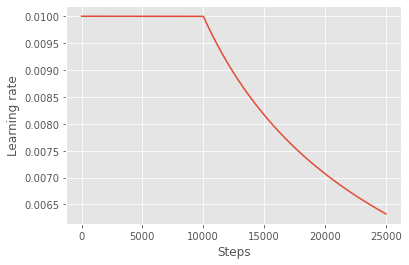

In [14]:
plt.style.use('ggplot')
schedule = CustomSchedule()
plt.plot(schedule(tf.range(25000, dtype = tf.float32)))
plt.xlabel("Steps")
plt.ylabel("Learning rate")

### Callbacks and Metrics

In [15]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = "val_accuracy", patience = 2, restore_best_weights = True
)

callbacks = [early_stopping] 
metrics = [tf.keras.metrics.SparseTopKCategoricalAccuracy(name = 'accuracy') ]